In [21]:
import xarray as xr

# Load each file individually (if you are working with multiple files)
ds_nov = xr.open_dataset("/home/bsc/bsc148104/2019_11_100si_timestep_60_monthly_mean.nc")
ds_dec = xr.open_dataset("/home/bsc/bsc148104/2019_12_100si_timestep_60_monthly_mean.nc")

# Concatenate along time
ds_combined = xr.concat([ds_nov, ds_dec], dim='time')

# Access the wind speed variable
wind_combined = ds_combined["100si"]

print(wind_combined)


<xarray.DataArray '100si' (time: 2, level: 1, lat: 1800, lon: 3600)> Size: 104MB
array([[[[ 8.21973605,  8.21973605,  8.21973605, ...,  7.93155878,
           7.93155878,  7.93155878],
         [ 8.69684516,  8.69684516,  8.69684516, ...,  8.38264009,
           8.38264009,  8.38264009],
         [ 8.8968595 ,  8.8968595 ,  8.8968595 , ...,  8.61651456,
           8.61651456,  8.61651456],
         ...,
         [ 7.32203924,  7.32203924,  7.32203924, ...,  7.25531669,
           7.25531669,  7.25531669],
         [ 7.34336095,  7.34336095,  7.34336095, ...,  7.27752125,
           7.27752125,  7.27752125],
         [ 7.37131588,  7.37131588,  7.37131588, ...,  7.29535562,
           7.29535562,  7.29535562]]],


       [[[ 5.84002793,  5.84002793,  5.84002793, ...,  5.65282625,
           5.65282625,  5.65282625],
         [ 6.1773337 ,  6.1773337 ,  6.1773337 , ...,  5.94997441,
           5.94997441,  5.94997441],
         [ 6.38724886,  6.38724886,  6.38724886, ...,  6.12959431,
  

In [22]:
# Apply the mask function
masked_wind_val = onshore_mask(
    variable_data=wind_combined,
    mask_file="/gpfs/scratch/bsc32/bsc032984/data/destine/masks/offshore_onshore_mask_global_10km_100_shifted.nc"
)

In [23]:
masked_wind_val

<xarray.DataArray '100si' (time: 2, level: 1, lat: 1800, lon: 3600)> Size: 104MB
array([[[[7.19209694, 7.02668624, 7.02668624, ..., 7.19209694,
          7.19209694,        nan],
         [6.48927767, 6.43261469, 6.43261469, ..., 6.48927767,
          6.48927767,        nan],
         [6.46810452, 6.45123411, 6.45123411, ..., 6.46810452,
          6.46810452,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]]],


       [[[5.2908699 , 5.15038371, 5.15038371, ..., 5.2908699 ,
          5.2908699 ,        nan],
         [5.04214554, 4.92784616, 4.92784616, ..., 5.04214554,
          5.04214554,        nan],
         [5.14179557, 5.04514904, 5.04514904, ..., 5.14179557,
          5.14179557,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]]]])
Coordinates:
  * level    (level) int64 8B 100
  * lat      (lat) float64 14kB -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * time     (time) datetime64[ns] 16B 2019-11-01 2019-12-01
  * lon      (lon) float64 29kB -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
Attributes:
    shortname:    onshore_mask_100si
    longname:     Onshore Mask Applied Variable: 100 metre wind speed
    units:        m s**-1
    description:  Masked variable using onshore mask (NaNs over excluded area...
    Contact:      BSC Energy Application Team (energy-destine@bsc.es) Respons...

In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from cartopy.util import add_cyclic_point
import matplotlib.colors as mpc
import matplotlib.ticker as ticker
from matplotlib import colormaps

def plot_map(data, xmin, xmax, colormap, label, title, delta=12, region='global', type='pcolormesh', extend='neither', projection='robinson'):
    """
    Plot a global or regional map with proper projection and cyclic point handling.
    Automatically handles NaN masking and selects appropriate normalization.
    """

    # Choose projection
    if projection == 'robinson':
        proj = ccrs.Robinson()
    else:
        proj = ccrs.PlateCarree()

    fig = plt.figure(figsize=(14, 8))
    ax = plt.axes(projection=proj)

    # Set region extent
    if region == 'eur':
        ax.set_extent([-25, 45, 27, 72], crs=ccrs.PlateCarree())
    elif region == 'iber':
        ax.set_extent([-10, 5, 35, 45], crs=ccrs.PlateCarree())
    elif region == 'nsea':
        ax.set_extent([-5, 5, 50.025, 59.975], crs=ccrs.PlateCarree())

    # Add map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.RIVERS, edgecolor='blue', alpha=0.3)

    # Ensure longitude format -180 to 180
    if data.lon.max() > 180:
        data = data.assign_coords(lon=(((data.lon + 180) % 360) - 180)).sortby('lon')

    # Add cyclic point to avoid gaps
    var_cyclic, lon_cyclic = add_cyclic_point(data.values, coord=data.lon.values)
    lon2d, lat2d = np.meshgrid(lon_cyclic, data.lat.values)

    # Setup colormap and NaN handling
    cmap = colormaps.get_cmap(colormap).copy()
    cmap.set_bad(color=(0, 0, 0, 0))  # Fully transparent for NaN (required by Cartopy)

    # Select normalization: Use PowerNorm for continuous data, Normalize for mask
    unique_values = np.unique(data.values[~np.isnan(data.values)])
    if len(unique_values) == 1:  # Likely a binary mask
        norm = plt.Normalize(vmin=xmin, vmax=xmax)
    else:  # Continuous data
        norm = mpc.PowerNorm(gamma=1, vmin=xmin, vmax=xmax)

    # Plot the data
    if type == 'pcolormesh':
        cs = ax.pcolormesh(lon2d, lat2d, var_cyclic, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    elif type == 'contourf':
        clevs = np.linspace(xmin, xmax, 256)
        cs = ax.contourf(lon2d, lat2d, var_cyclic, levels=clevs, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, extend=extend)

    # Add colorbar
    cbar = plt.colorbar(cs, orientation='horizontal', pad=0.05, fraction=0.04)
    cbar.set_label(label, fontsize=14)
    tick_locator = ticker.MaxNLocator(nbins=delta // 2)
    cbar.locator = tick_locator
    cbar.update_ticks()

    # Add title
    ax.set_title(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [25]:
#Plotting libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cmocean import cm as cmo
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as pltmask
import matplotlib.gridspec as gs
from matplotlib.ticker import ScalarFormatter
import matplotlib.patches as patches
import matplotlib.colors as mpc
%matplotlib inline

In [ ]:
# choose Dec wind speed 
plot_data=masked_wind_val.isel(time=1).isel(level=0)

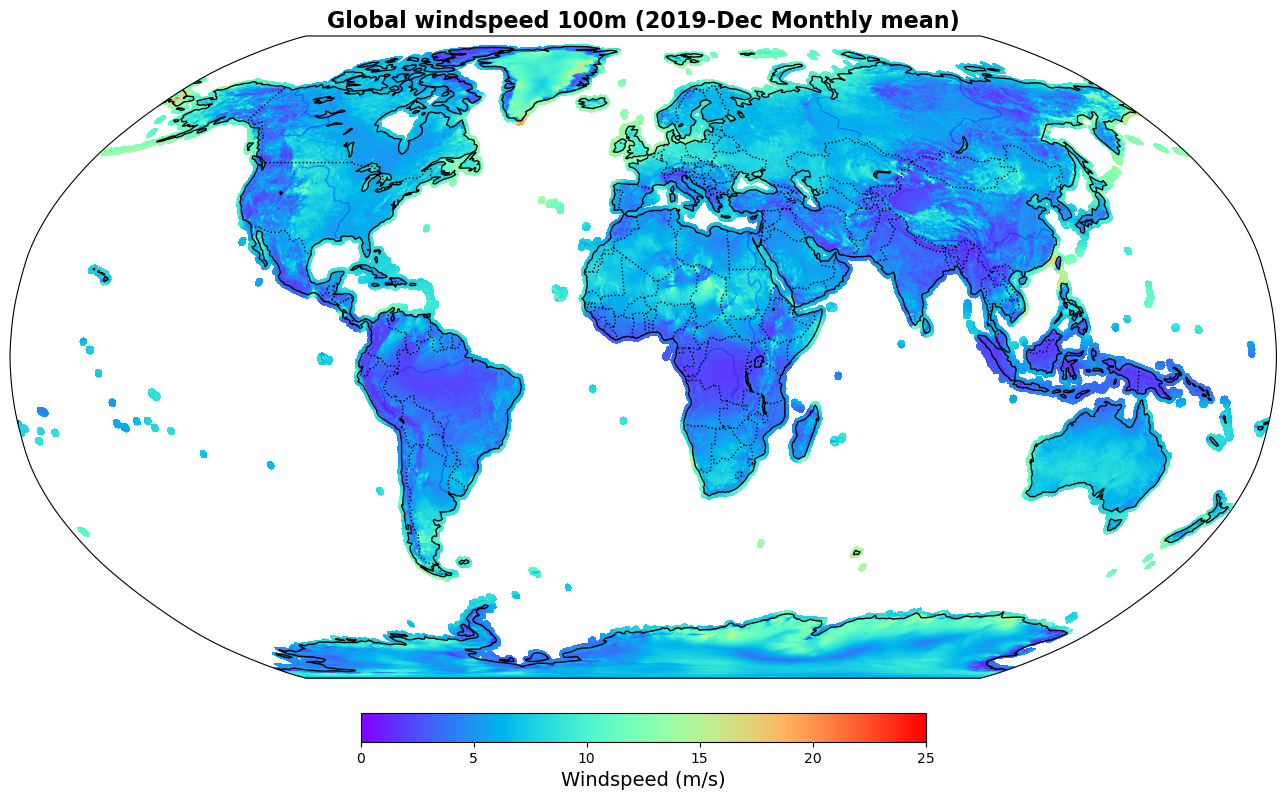

In [27]:
plot_map(
    plot_data,
    xmin=0, xmax=25,
    colormap="rainbow",
    label="Windspeed (m/s)",
    title="Global windspeed 100m (2019-Dec Monthly mean)",
    delta=10,
    projection='robinson',
    type='contourf',
    extend='neither'
)